In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Set the font family to Tahoma
plt.rcParams['font.family'] = 'Tahoma'

In [3]:
# Dictionary to map Thai month abbreviations to month numbers
thai_months = {
    "ม.ค.": 1,
    "ก.พ.": 2,
    "มี.ค.": 3,
    "เม.ย.": 4,
    "พ.ค.": 5,
    "มิ.ย.": 6,
    "ก.ค.": 7,
    "ส.ค.": 8,
    "ก.ย.": 9,
    "ต.ค.": 10,
    "พ.ย.": 11,
    "ธ.ค.": 12
}

def convert_thai_date(thai_date):
    # Split the input string
    thai_month_abbr, buddhist_year = thai_date.split("-")
    
    # Convert the Thai month abbreviation to a month number
    month = thai_months[thai_month_abbr.strip()]
    
    # Convert the Buddhist year to Gregorian year
    year = int(buddhist_year.strip())
    if year >= 75:
        year += 1900
    else:
        year += 2000
    # Use the first day of the month for the conversion
    day = 1
    
    # Create a datetime object
    date = datetime(year, month, day)
    
    # Return the formatted date in "Y-M-d" format
    return date.strftime("%Y-%m-%d")

In [4]:
df = pd.read_csv('./Table_PBV.csv', skiprows=3)
df['SET'] = df['SET'].str.replace(',', '')

set_index = pd.read_csv('./Table_Index.csv', skiprows=3)
set_index['SET'] = set_index['SET'].str.replace(',', '')

In [5]:
# set_index['Month-Year'].head(50)

In [6]:
df['SET'] = pd.to_numeric(df['SET'], errors='coerce')
set_index['SET'] = pd.to_numeric(set_index['SET'], errors='coerce')

In [7]:
selected_df = df[['Month-Year', 'SET']].dropna(axis=0)[::-1].copy()
set_index = set_index[['Month-Year', 'SET']].dropna(axis=0)[::-1].copy()

In [8]:
selected_df['Month-Year'] = selected_df['Month-Year'].apply(convert_thai_date)
selected_df['Month-Year'] = pd.to_datetime(selected_df['Month-Year'])

set_index['Month-Year'] = set_index['Month-Year'].apply(convert_thai_date)
set_index['Month-Year'] = pd.to_datetime(set_index['Month-Year'])

In [9]:
selected_df.set_index('Month-Year', inplace=True)
set_index.set_index('Month-Year', inplace=True)

In [10]:
selected_df['set-index'] = set_index

In [11]:
selected_df

,SET,set-index
Month-Year,,
1988-04-01,3.07,413.91
1988-05-01,3.16,424.93
1988-06-01,3.52,452.70
1988-07-01,3.51,457.01
1988-08-01,3.33,436.55
...,...,...
2024-02-01,1.33,1370.67
2024-03-01,1.33,1377.94
2024-04-01,1.32,1367.95


In [12]:
selected_df['log-SET'] = np.log(selected_df['SET'])

In [13]:
# selected_df['SET'][::-1].cumprod()** (1 / np.arange(1, len(selected_df)+1))
selected_df['gmean-SET'] = np.exp(selected_df['log-SET'].cumsum() / np.arange(1, len(selected_df)+1))

In [14]:
selected_df['scaled-SET'] = selected_df['SET'] / selected_df['gmean-SET'].shift()

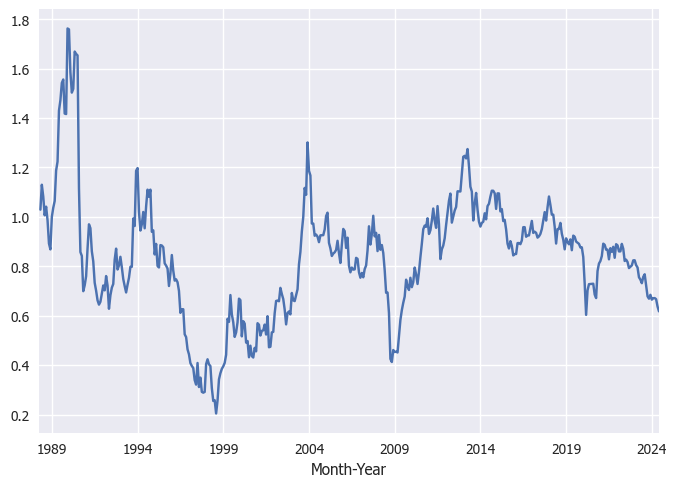

In [15]:
selected_df['scaled-SET'].plot();

In [16]:
n = 4
selected_df['quarter'], bins = pd.qcut(selected_df['scaled-SET'], q=n, labels=False, retbins=True)

In [17]:
bins

array([0.20427023, 0.68825346, 0.85390345, 0.96067702, 1.76269296])

In [18]:
selected_df['ret'] = selected_df['set-index'].pct_change()

In [22]:
selected_df['quarter-shift'] = selected_df['quarter'].shift(1)

In [37]:
state_switching = []
for (present, past) in zip(selected_df['quarter'], selected_df['quarter-shift']):
    if np.isnan(present) or np.isnan(past):
        state_switching.append(np.nan)
    else:
        state_switching.append(f'{int(past)}=>{int(present)}')

In [39]:
selected_df['regime-switching'] = state_switching

In [43]:
selected_df['regime-switching'].value_counts()

regime-switching
0=>0    100
3=>3     91
1=>1     84
2=>2     77
3=>2     17
2=>3     16
2=>1     15
1=>2     14
1=>0      9
0=>1      8
1=>3      1
3=>1      1
Name: count, dtype: int64

In [57]:
selected_df[selected_df['regime-switching'] == '1=>3']

,SET,set-index,log-SET,gmean-SET,scaled-SET,quarter,ret,quarter-shift,regime-switching
Month-Year,,,,,,,,,
1993-10-01,3.61,1260.91,1.283708,3.63425,0.993227,3.0,0.29798,1.0,1=>3


In [60]:
m = 100000
d = 12

for i in selected_df['regime-switching'].dropna().unique():

    mask_index = selected_df[selected_df['regime-switching'] == i].index
    rets = []
    for mi in mask_index:
        rets += selected_df.loc[mi: mi + pd.DateOffset(months=11)]['ret'].tolist()
    
    bootstrapping_sample = np.random.choice(rets, size=(m, d), replace=True) + 1
        
    ret_rest = np.prod(bootstrapping_sample, axis=1)
    
    # plt.hist(ret_rest, bins=100)
    # plt.title(f'Class:{i}\nGrowth: {np.median(ret_rest):.2f}\n5th: {np.quantile(ret_rest, 0.05):.2f}\n95th: {np.quantile(ret_rest, 0.95):.2f}')
    # plt.show()
    
    print(f'''
    Class:{i}
    growth rate (median): {np.median(ret_rest):.2f}
    mean: {np.mean(ret_rest):.2f}
    std: {np.std(ret_rest):.2f}
    5th: {np.quantile(ret_rest, 0.05):.2f}
    95th: {np.quantile(ret_rest, 0.95):.2f}''')
    


    Class:3=>3
    growth rate (median): 1.07
    mean: 1.09
    std: 0.27
    5th: 0.69
    95th: 1.56

    Class:3=>2
    growth rate (median): 0.96
    mean: 0.97
    std: 0.23
    5th: 0.63
    95th: 1.37

    Class:2=>2
    growth rate (median): 0.97
    mean: 0.98
    std: 0.18
    5th: 0.68
    95th: 1.29

    Class:2=>3
    growth rate (median): 1.10
    mean: 1.12
    std: 0.24
    5th: 0.77
    95th: 1.54

    Class:2=>1
    growth rate (median): 0.96
    mean: 0.99
    std: 0.23
    5th: 0.65
    95th: 1.41

    Class:1=>1
    growth rate (median): 1.08
    mean: 1.11
    std: 0.28
    5th: 0.73
    95th: 1.62

    Class:1=>2
    growth rate (median): 1.15
    mean: 1.18
    std: 0.22
    5th: 0.86
    95th: 1.56

    Class:1=>0
    growth rate (median): 1.02
    mean: 1.05
    std: 0.29
    5th: 0.62
    95th: 1.58

    Class:0=>0
    growth rate (median): 1.00
    mean: 1.07
    std: 0.43
    5th: 0.52
    95th: 1.88

    Class:0=>1
    growth rate (median): 1.41
    mean

Explanation for combined actions:
1. Hold: For growth rates close to 1 with low volatility.
2. Sell/Put: For growth rates below 1, with "Put" used for high volatility.
3. Buy/Call: For growth rates above 1, with "Call" used for high volatility.

We will use the following thresholds:

- Growth rate < 1: Sell/Put
- Growth rate > 1: Buy/Call
- Growth rate close to 1: Hold
- Low volatility: std < 0.25
- High volatility: std >= 0.25

- Buy/Call: High growth rate (> 1) with high volatility (std >= 0.25)
- Sell/Put: Low growth rate (< 1) with high volatility (std >= 0.25)

![Action Table](action-tatble.png)

| From Class | To Class | Median Growth Rate | Mean Growth Rate | Std Dev | 5th Percentile | 95th Percentile | Actions             | Explanation |
|------------|----------|---------------------|-------------------|---------|----------------|-----------------|----------------------|-------------|
| 1          | 3        | 1.51                | 1.68              | 0.76    | 0.78           | 3.12            | call, put            | Very high growth with extreme volatility |
| 0          | 1        | 1.41                | 1.44              | 0.33    | 0.97           | 2.04            | buy, call            | Strong growth with high potential |
| 2          | 3        | 1.10                | 1.12              | 0.24    | 0.77           | 1.54            | buy, call            | Strong growth, opportunity for further gains |
| 1          | 2        | 1.15                | 1.18              | 0.22    | 0.86           | 1.56            | buy, call            | Strong growth, opportunity for further gains |
| 3          | 1        | 1.17                | 1.17              | 0.24    | 0.79           | 1.57            | put, call            | Strong growth but with potential risk |
| 1          | 1        | 1.08                | 1.11              | 0.28    | 0.73           | 1.62            | hold, dca            | Moderate growth, stable performance |
| 3          | 3        | 1.07                | 1.09              | 0.27    | 0.69           | 1.56            | hold, dca            | Moderate growth, stable performance |
| 1          | 0        | 1.02                | 1.05              | 0.29    | 0.62           | 1.58            | call, dca            | Moderate growth with some risk |
| 2          | 2        | 0.97                | 0.98              | 0.18    | 0.68           | 1.29            | hold, dca            | Stable but not strong growth |
| 3          | 2        | 0.96                | 0.97              | 0.23    | 0.63           | 1.37            | sell, dca            | Underperforming, moderate volatility |
| 2          | 1        | 0.96                | 0.99              | 0.23    | 0.65           | 1.41            | sell, dca            | Underperforming, but stable |
| 0          | 0        | 1.00                | 1.07              | 0.43    | 0.52           | 1.88            | hold, dca            | Stable but highvolatility |
ntial risk |
